## Imports

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

## Part 1: Data Preprocessing

In [26]:
# Define transform to normalize the data to [0,1]
transform = transforms.ToTensor()

# Load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Data loaders, for batching and shuffling
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Part 2: Building the CNN model

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # First convolution layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Second convolution layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # Fully connected dense layer
        self.fc2 = nn.Linear(128, 10) # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply first convolution, ReLU, and max pooling (28x28 -> 14x14)
        x = self.pool(F.relu(self.conv2(x)))  # Apply second convolution, ReLU, and max pooling (14x14 -> 7x7)
        x = x.view(-1, 64 * 7 * 7) # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x)) # Apply ReLU activation after the first dense layer
        x = self.fc2(x) # Output layer
        return x

model = CNN()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

## Part 3: Training and Evaluation

In [28]:
train_losses, val_losses = [], []

# Train for 5 epochs
for epoch in range(5):
    model.train()
    running_loss = 0 # To accumulate loss over the epoch
    for images, labels in train_loader: # Training loop
        optimizer.zero_grad() # Reset gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update model weights
        running_loss += loss.item() # Add current batch loss to running total

    train_losses.append(running_loss / len(train_loader)) # Average training loss for the epoch

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad(): # No gradient calculation during validation
        for images, labels in val_loader:
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            val_loss += loss.item() # Add batch loss to total
    val_losses.append(val_loss / len(val_loader)) # Average validation loss for the epoch

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

Epoch 1: Train Loss = 0.4822, Val Loss = 0.3680
Epoch 2: Train Loss = 0.3084, Val Loss = 0.3122
Epoch 3: Train Loss = 0.2594, Val Loss = 0.2693
Epoch 4: Train Loss = 0.2294, Val Loss = 0.2536
Epoch 5: Train Loss = 0.2008, Val Loss = 0.2491


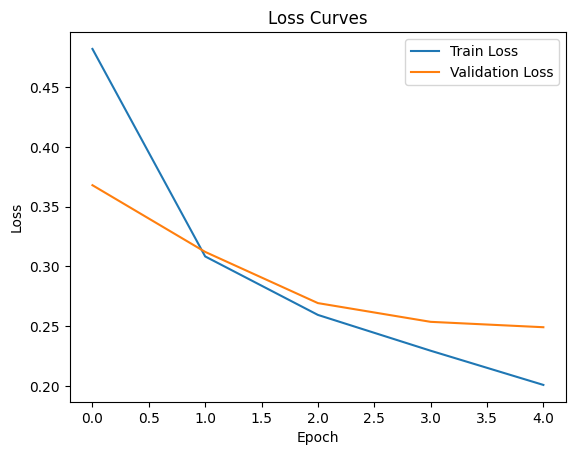

In [29]:
# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [30]:
# Evaluate on Test Set
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.66%


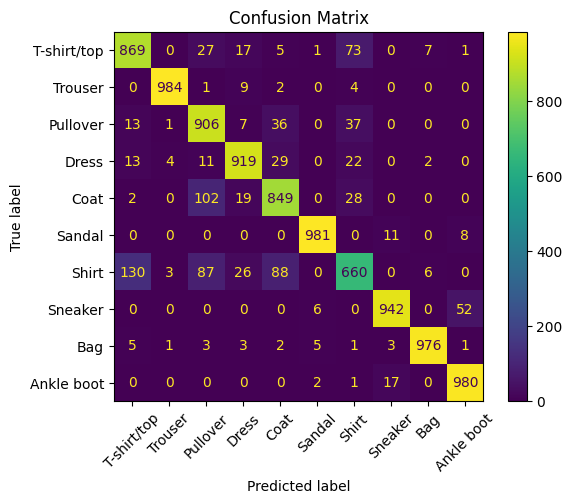

In [31]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [48]:
# Classification metrics
baseline_report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)

baseline_precision = baseline_report['weighted avg']['precision']
baseline_recall = baseline_report['weighted avg']['recall']
baseline_f1 = baseline_report['weighted avg']['f1-score']

print("Baseline CNN:")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall   : {baseline_recall:.4f}")
print(f"F1-Score : {baseline_f1:.4f}")

Baseline CNN:
Precision: 0.9067
Recall   : 0.9066
F1-Score : 0.9056


## Part 4: Experimentation

In [32]:
class CNNImproved(nn.Module):
    def __init__(self):
        super(CNNImproved, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Add Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Add Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3) # Add Dropout
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Add Batch Normalization
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Add Batch Normalization
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x))) # Add Dropout
        x = self.fc2(x)
        return x

# Instantiate model, loss, and optimizer
model_improved = CNNImproved()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_improved.parameters(), lr=0.001)

In [33]:
# Train improved model
train_losses_improved, val_losses_improved = [], []

for epoch in range(5):
    model_improved.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_improved(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses_improved.append(running_loss / len(train_loader))

    model_improved.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_improved(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses_improved.append(val_loss / len(val_loader))

    print(f"[Experimentation] Epoch {epoch+1}: Train Loss = {train_losses_improved[-1]:.4f}, Val Loss = {val_losses_improved[-1]:.4f}")

[Experimentation] Epoch 1: Train Loss = 0.4507, Val Loss = 0.3284
[Experimentation] Epoch 2: Train Loss = 0.3159, Val Loss = 0.2665
[Experimentation] Epoch 3: Train Loss = 0.2688, Val Loss = 0.2421
[Experimentation] Epoch 4: Train Loss = 0.2452, Val Loss = 0.2394
[Experimentation] Epoch 5: Train Loss = 0.2235, Val Loss = 0.2248


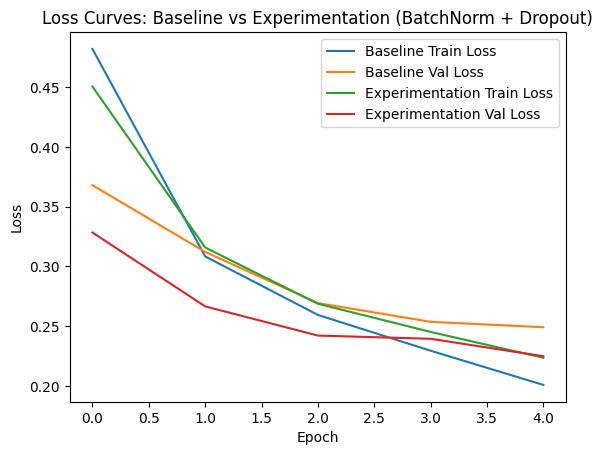

In [34]:
# Compare loss curves
plt.plot(train_losses, label='Baseline Train Loss')
plt.plot(val_losses, label='Baseline Val Loss')
plt.plot(train_losses_improved, label='Experimentation Train Loss')
plt.plot(val_losses_improved, label='Experimentation Val Loss')
plt.title("Loss Curves: Baseline vs Experimentation (BatchNorm + Dropout)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
# Evaluate Improved Model on Test Set
model_improved.eval()
correct_improved = 0
all_preds_improved = []
all_labels_improved = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_improved(images)
        _, predicted = torch.max(outputs, 1)
        correct_improved += (predicted == labels).sum().item()
        all_preds_improved.extend(predicted.cpu().numpy())
        all_labels_improved.extend(labels.cpu().numpy())

accuracy_improved = 100 * correct_improved / len(test_dataset)
print(f"Experimentation (with BatchNorm & Dropout) Test Accuracy: {accuracy_improved:.2f}%")

Experimentation (with BatchNorm & Dropout) Test Accuracy: 91.18%


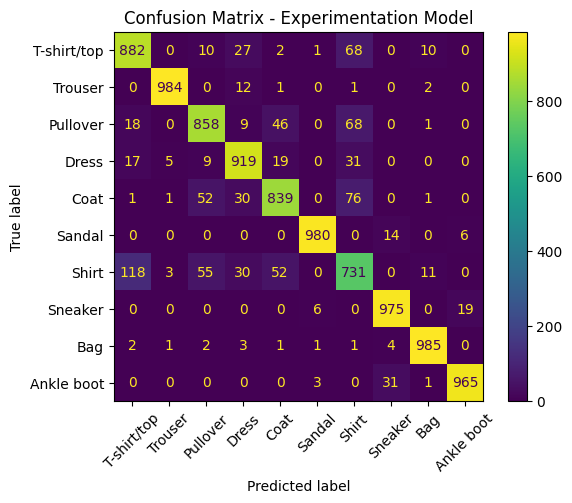

In [36]:
# Confusion Matrix for Improved Model
cm_improved = confusion_matrix(all_labels_improved, all_preds_improved)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Experimentation Model")
plt.show()

In [49]:
# Classification metrics
improved_report = classification_report(all_labels_improved, all_preds_improved, target_names=train_dataset.classes, output_dict=True)

improved_precision = improved_report['weighted avg']['precision']
improved_recall = improved_report['weighted avg']['recall']
improved_f1 = improved_report['weighted avg']['f1-score']

print("Experimentation CNN:")
print(f"Precision: {improved_precision:.4f}")
print(f"Recall   : {improved_recall:.4f}")
print(f"F1-Score : {improved_f1:.4f}")

Experimentation CNN:
Precision: 0.9115
Recall   : 0.9118
F1-Score : 0.9115


In [37]:
# Final Comparison
print("=== Final Comparison ===")
print(f"Baseline Accuracy  : {accuracy:.2f}%")
print(f"Experimentation Accuracy  : {accuracy_improved:.2f}%")

=== Final Comparison ===
Baseline Accuracy  : 90.66%
Experimentation Accuracy  : 91.18%
